# Preprocess/Cleanup

In [1]:
#imported python packages
import numpy as np
import pandas as pd
from math import sqrt

from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance
import lightgbm as lgb
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import mean_squared_error

import time

In [2]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

2022-12-12 16:39:54.327166: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 16:39:54.702916: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-12 16:39:54.780238: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-12 16:39:54.780260: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [3]:
#imported dataset about categories of items
i_cat = pd.read_csv('Sales/item_categories.csv')


In [4]:
i_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [5]:

i_cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [6]:
#imported dataset of items
items = pd.read_csv('Sales/items.csv')
items.info()
items.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [7]:
#imported dataset about shops
shops = pd.read_csv("Sales/shops.csv")
shops.info()
shops.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [8]:
#imported dataset. this is the training dataset
train = pd.read_csv('Sales/sales_train.csv',parse_dates = ['date'], infer_datetime_format = True, dayfirst = True)
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [9]:
#imported the testing dataset
test = pd.read_csv('Sales/test.csv')
test.info()
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [10]:
# The is sample of our final result
sample_submission = pd.read_csv('Sales/sample_submission.csv')
sample_submission.info()
sample_submission.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ID              214200 non-null  int64  
 1   item_cnt_month  214200 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 3.3 MB


,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


## Cleanup

In [11]:
# Checked if there are any null values
print("No. of Null values in the train_df set :", train.isnull().sum().sum())
print("No. of Null values in the test set :", test.isnull().sum().sum())
print("No. of Null values in the item set :", items.isnull().sum().sum())
print("No. of Null values in the shops set :", shops.isnull().sum().sum())
print("No. of Null values in the item_categories set :", i_cat.isnull().sum().sum())

No. of Null values in the train_df set : 0
No. of Null values in the test set : 0
No. of Null values in the item set : 0
No. of Null values in the shops set : 0
No. of Null values in the item_categories set : 0


<AxesSubplot:xlabel='item_price'>

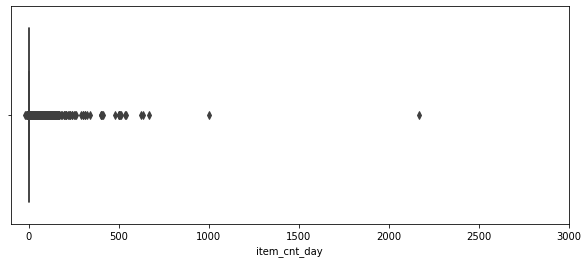

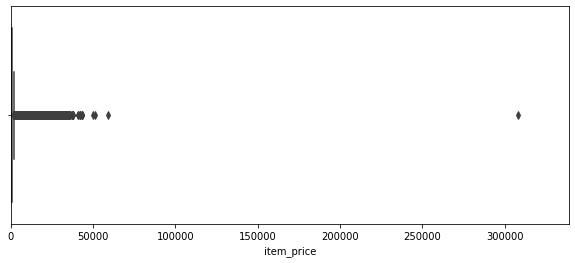

In [12]:
# Checked for outliers
# remove items with price > 1000000 and sales > 1001
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [13]:
# remove outliers
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

In [14]:
# check if itme price is below 0
train[train.item_price<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


In [15]:
# replace the item price with the median of that particular instance
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

In [16]:
#check if there are duplicated values for each index
train.duplicated()

0          False
1          False
2          False
3          False
4          False
           ...  
2935844    False
2935845    False
2935846    False
2935847    False
2935848    False
Length: 2935847, dtype: bool

In [17]:
#check if there are duplicated shops
shops.duplicated()

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
40    False
41    False
42    False
43    False
44    False
45    False
46    False
47    False
48    False
49    False
50    False
51    False
52    False
53    False
54    False
55    False
56    False
57    False
58    False
59    False
dtype: bool

## Attempting to create and add various columns to training dataset for data modeling 

In [18]:
# Seperated the city name from shop name
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
# Gave each city a code
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])

# Seperate the category name of each item
i_cat['split'] = i_cat['item_category_name'].str.split('-')
# Get the type of category from the split
i_cat['type'] = i_cat['split'].map(lambda x: x[0].strip())
# Give each type a code
i_cat['type_code'] = LabelEncoder().fit_transform(i_cat['type'])
# seperate subtype, which is the second part of category name in split
# if the second part is nan then consider first part
i_cat['subtype'] = i_cat['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
# Give a code to each subtype
i_cat['subtype_code'] = LabelEncoder().fit_transform(i_cat['subtype'])


In [19]:
# shown how the above process executed for shops
shops

,shop_name,shop_id,city,city_code
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск,0
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск,0
2,"Адыгея ТЦ ""Мега""",2,Адыгея,1
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,2
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,3
5,"Вологда ТРЦ ""Мармелад""",5,Вологда,4
6,"Воронеж (Плехановская, 13)",6,Воронеж,5
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж,5
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж,5
9,Выездная Торговля,9,Выездная,6


In [20]:
# shown how the above process executed for item category
i_cat

,item_category_name,item_category_id,split,type,type_code,subtype,subtype_code
0,PC - Гарнитуры/Наушники,0,"[PC , Гарнитуры/Наушники]",PC,0,Гарнитуры/Наушники,29
1,Аксессуары - PS2,1,"[Аксессуары , PS2]",Аксессуары,1,PS2,9
2,Аксессуары - PS3,2,"[Аксессуары , PS3]",Аксессуары,1,PS3,10
3,Аксессуары - PS4,3,"[Аксессуары , PS4]",Аксессуары,1,PS4,11
4,Аксессуары - PSP,4,"[Аксессуары , PSP]",Аксессуары,1,PSP,13
...,...,...,...,...,...,...,...
79,Служебные,79,[Служебные],Служебные,16,Служебные,54
80,Служебные - Билеты,80,"[Служебные , Билеты]",Служебные,16,Билеты,25
81,Чистые носители (шпиль),81,[Чистые носители (шпиль)],Чистые носители (шпиль),17,Чистые носители (шпиль),62
82,Чистые носители (штучные),82,[Чистые носители (штучные)],Чистые носители (штучные),18,Чистые носители (штучные),63


In [21]:
# updated dataset of shops
shops = shops[['shop_id','city_code']]

In [22]:
# updated dataset of item category
i_cat = i_cat[['item_category_id','type_code', 'subtype_code']]

In [23]:
# calculated revenue for each instance of train dataset
train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [24]:
# create a dataset of no. of items sold per month for each month, shop and item 
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)


In [25]:
group

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0
...,...,...,...,...
1609118,33,59,22087,6.0
1609119,33,59,22088,2.0
1609120,33,59,22091,1.0
1609121,33,59,22100,1.0


In [26]:
# new dataset created to use for modeling, merged with the above group
train_df = pd.merge(train, group, on=['date_block_num','shop_id','item_id'])

In [27]:
train_df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue,item_cnt_month
0,2013-01-02,0,59,22154,999.00,1.0,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0,899.00,0.0
2,2013-01-05,0,25,2552,899.00,-1.0,-899.00,0.0
3,2013-01-06,0,25,2554,1709.05,1.0,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0,1099.00,1.0
...,...,...,...,...,...,...,...,...
2935842,2015-10-10,33,25,7409,299.00,1.0,299.00,3.0
2935843,2015-10-11,33,25,7393,349.00,1.0,349.00,1.0
2935844,2015-10-10,33,25,7384,749.00,1.0,749.00,1.0
2935845,2015-10-14,33,25,7459,349.00,1.0,349.00,1.0


In [28]:
# modified test dataset to merge with training dataset. Changed theype for xgbboost
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [29]:
# the item name is dropped and its coded version will be added to train dataset
items.drop(['item_name'], axis=1, inplace=True)

In [30]:
# added columns of days, month, week, and year
train['day'] = pd.DatetimeIndex(train['date']).day
train['week'] = pd.DatetimeIndex(train['date']).week
train['year'] = pd.DatetimeIndex(train['date']).year
train['month'] = pd.DatetimeIndex(train['date']).month
train['year'].unique()

/tmp/ipykernel_339/2427532665.py:3: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  train['week'] = pd.DatetimeIndex(train['date']).week


array([2013, 2014, 2015])

In [31]:
train.to_csv('Sales.csv',index=False)

In [32]:
# merged train and test dataset
train_df = pd.concat([train_df, test], ignore_index=True, sort=False, keys=['date_block_num','shop_id','item_id'])
train_df.fillna(0, inplace=True) # 34 month

In [33]:
train_df.drop(['date'],axis=1,inplace=True)

In [34]:
# merged the shop,items, and item category datasets to train_df 
train_df = pd.merge(train_df, shops, on=['shop_id'], how='left')
train_df = pd.merge(train_df, items, on=['item_id'], how='left')
train_df = pd.merge(train_df, i_cat, on=['item_category_id'], how='left')

In [35]:
train_df

,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code
0,0,59,22154,999.00,1.0,999.00,1.0,0.0,31,37,11,1
1,0,25,2552,899.00,1.0,899.00,0.0,0.0,14,58,13,27
2,0,25,2552,899.00,-1.0,-899.00,0.0,0.0,14,58,13,27
3,0,25,2554,1709.05,1.0,1709.05,1.0,0.0,14,58,13,27
4,0,25,2555,1099.00,1.0,1099.00,1.0,0.0,14,56,13,3
...,...,...,...,...,...,...,...,...,...,...,...,...
3150042,34,45,18454,0.00,0.0,0.00,0.0,214195.0,21,55,13,2
3150043,34,45,16188,0.00,0.0,0.00,0.0,214196.0,21,64,14,42
3150044,34,45,15757,0.00,0.0,0.00,0.0,214197.0,21,55,13,2
3150045,34,45,19648,0.00,0.0,0.00,0.0,214198.0,21,40,11,4


In [36]:
test

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34
...,...,...,...,...
214195,214195,45,18454,34
214196,214196,45,16188,34
214197,214197,45,15757,34
214198,214198,45,19648,34


In [37]:
# changed data type for xgbboost
train_df['date_block_num'] = train_df['date_block_num'].astype(np.int8)
train_df['shop_id'] = train_df['shop_id'].astype(np.int8)
train_df['item_id'] = train_df['item_id'].astype(np.int16)
train_df['item_cnt_month'] = (train_df['item_cnt_month'].fillna(0).clip(0,20).astype(np.float16))
train_df['city_code'] = train_df['city_code'].astype(np.int8)
train_df['item_category_id'] = train_df['item_category_id'].astype(np.int8)
train_df['type_code'] = train_df['type_code'].astype(np.int8)
train_df['subtype_code'] = train_df['subtype_code'].astype(np.int8)

In [38]:
# create a dataset on average no. of items sold per month for each month
group = train_df.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)
# merge the group with train_df
train_df = pd.merge(train_df, group, on=['date_block_num'], how='left')
train_df['date_avg_item_cnt'] = train_df['date_avg_item_cnt'].astype(np.float16)

In [39]:
train_df.drop(['ID'],axis=1,inplace=True)

In [40]:
# create a dataset on mean no. of items sold per month for each month and item_id
group = train_df.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)
# merge the group with train_df
train_df = pd.merge(train_df, group, on=['date_block_num','item_id'], how='left')
train_df['date_item_avg_item_cnt'] = train_df['date_item_avg_item_cnt'].astype(np.float16)


In [41]:
# create a dataset on mean no. of items sold per month for each month and shop_id
group = train_df.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)
# merge the group with train_df
train_df = pd.merge(train_df, group, on=['date_block_num','shop_id'], how='left')
train_df['date_shop_avg_item_cnt'] = train_df['date_shop_avg_item_cnt'].astype(np.float16)


In [42]:
# create a dataset on mean no. of items sold per month for each month and item_category_id
group = train_df.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)
# merge the group with train_df
train_df = pd.merge(train_df, group, on=['date_block_num','item_category_id'], how='left')
train_df['date_cat_avg_item_cnt'] = train_df['date_cat_avg_item_cnt'].astype(np.float16)

In [43]:
# create a dataset on mean no. of items sold per month for each month and shop_id and item_category_id
group = train_df.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)
# merge the group with train_df
train_df = pd.merge(train_df, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')

train_df['date_shop_cat_avg_item_cnt'] = train_df['date_shop_cat_avg_item_cnt'].astype(np.float16)


In [44]:
# create a dataset on mean no. of items sold per month for each month and shop_id and type_code
group = train_df.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)
# merge the group with train_df
train_df = pd.merge(train_df, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
train_df['date_shop_type_avg_item_cnt'] = train_df['date_shop_type_avg_item_cnt'].astype(np.float16)


In [45]:
# create a dataset on mean no. of items sold per month for each month and shop_id and subtype_code
group = train_df.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)
# merge the group with train_df
train_df = pd.merge(train_df, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
train_df['date_shop_subtype_avg_item_cnt'] = train_df['date_shop_subtype_avg_item_cnt'].astype(np.float16)


In [46]:
# create a dataset on mean no. of items sold per month for each month and city_code
group = train_df.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)
# merge the group with train_df
train_df = pd.merge(train_df, group, on=['date_block_num', 'city_code'], how='left')
train_df['date_city_avg_item_cnt'] = train_df['date_city_avg_item_cnt'].astype(np.float16)


In [47]:
# create a dataset on mean no. of items sold per month for each month and item_id and city_code
group = train_df.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)
# merge the group with train_df
train_df = pd.merge(train_df, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
train_df['date_item_city_avg_item_cnt'] = train_df['date_item_city_avg_item_cnt'].astype(np.float16)


In [48]:
# create a dataset on mean no. of items sold per month for each month and type_code
group = train_df.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)
# merge the group with train_df
train_df = pd.merge(train_df, group, on=['date_block_num', 'type_code'], how='left')
train_df['date_type_avg_item_cnt'] = train_df['date_type_avg_item_cnt'].astype(np.float16)


In [49]:
# create a dataset on mean no. of items sold per month for each month and subtype_code
group = train_df.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)
# merge the group with train_df
train_df = pd.merge(train_df, group, on=['date_block_num', 'subtype_code'], how='left')
train_df['date_subtype_avg_item_cnt'] = train_df['date_subtype_avg_item_cnt'].astype(np.float16)


In [50]:
# create a dataset on mean of item_price for each item_id
group = train_df.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)
# merge the group with train_df
train_df = pd.merge(train_df, group, on=['item_id'], how='left')
train_df['item_avg_item_price'] = train_df['item_avg_item_price'].astype(np.float16)


In [51]:
# create a dataset on mean of item_price for each month and item_id
group = train_df.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)
# merge the group with train_df
train_df = pd.merge(train_df, group, on=['date_block_num','item_id'], how='left')
train_df['date_item_avg_item_price'] = train_df['date_item_avg_item_price'].astype(np.float16)


In [52]:
# create a dataset on sum of revenue for each month and shop_id
group = train_df.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)
# merge the group with train_df
train_df = pd.merge(train_df, group, on=['date_block_num','shop_id'], how='left')
train_df['date_shop_revenue'] = train_df['date_shop_revenue'].astype(np.float32)

In [53]:
# create a dataset on mean of revenue per month and shop for each shop_id
group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)
# merge the group with train_df
train_df = pd.merge(train_df, group, on=['shop_id'], how='left')
train_df['shop_avg_revenue'] = train_df['shop_avg_revenue'].astype(np.float32)

In [54]:
#create a dataset on how close the date_shop_revenue is to shop_avg_revenue for each shop
train_df['delta_revenue'] = (train_df['date_shop_revenue'] - train_df['shop_avg_revenue']) / train_df['shop_avg_revenue']

In [55]:
train_df['delta_revenue'] = train_df['delta_revenue'].astype(np.float16)

In [56]:
# create a column representing month number for each date_block_num
train_df['month'] = train_df['date_block_num'] % 12

### This is the final dataframe used for Data Modeling

In [57]:
train_df

,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue,item_cnt_month,city_code,item_category_id,type_code,...,date_city_avg_item_cnt,date_item_city_avg_item_cnt,date_type_avg_item_cnt,date_subtype_avg_item_cnt,item_avg_item_price,date_item_avg_item_price,date_shop_revenue,shop_avg_revenue,delta_revenue,month
0,0,59,22154,999.00,1.0,999.00,1.0,31,37,11,...,3.835938,1.0,3.697266,2.462891,410.5000,999.0,1633431.0,1292188.000,0.264160,0
1,0,25,2552,899.00,1.0,899.00,0.0,14,58,13,...,5.152344,0.0,2.076172,1.252930,938.0000,899.0,5376478.0,6185159.000,-0.130737,0
2,0,25,2552,899.00,-1.0,-899.00,0.0,14,58,13,...,5.152344,0.0,2.076172,1.252930,938.0000,899.0,5376478.0,6185159.000,-0.130737,0
3,0,25,2554,1709.05,1.0,1709.05,1.0,14,58,13,...,5.152344,1.0,2.076172,1.252930,1709.0000,1709.0,5376478.0,6185159.000,-0.130737,0
4,0,25,2555,1099.00,1.0,1099.00,1.0,14,56,13,...,5.152344,1.0,2.076172,1.225586,1123.0000,1099.0,5376478.0,6185159.000,-0.130737,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3150042,34,45,18454,0.00,0.0,0.00,0.0,21,55,13,...,0.000000,0.0,0.000000,0.000000,173.7500,0.0,0.0,1169279.875,-1.000000,10
3150043,34,45,16188,0.00,0.0,0.00,0.0,21,64,14,...,0.000000,0.0,0.000000,0.000000,109.3125,0.0,0.0,1169279.875,-1.000000,10
3150044,34,45,15757,0.00,0.0,0.00,0.0,21,55,13,...,0.000000,0.0,0.000000,0.000000,178.0000,0.0,0.0,1169279.875,-1.000000,10
3150045,34,45,19648,0.00,0.0,0.00,0.0,21,40,11,...,0.000000,0.0,0.000000,0.000000,55.1875,0.0,0.0,1169279.875,-1.000000,10


In [58]:
# Saved the dataframe as a csv file
train_df.to_csv('train.csv',index=False)